# Imports

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import re

from keras.preprocessing.text import Tokenizer
import tensorflow as tf

from keras.utils import pad_sequences

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, GlobalMaxPool1D
from keras.layers import SimpleRNN

from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras.layers import Conv1D, MaxPool1D

import pickle

import tensorflow_hub as hub
import tensorflow_text as text

from utils import *

[nltk_data] Downloading package stopwords to /Users/dnb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dnb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2023-04-05 03:34:45.549420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Добавим/удалим некоторые элементы из стоп-листа

In [2]:
stoplist = stopwords.words('english')
more_elements = ["i'm", "i'd"]
less_elements = ["have", "don't", "when"]
stoplist.extend(more_elements)
for word in less_elements:
    stoplist.remove(word)

stoplist

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

## Предобработка данных

Данные 'text', 'intent' из файла 'data/intents_train.csv' -> датафрейм df_train.

Заодно, на будущее, данные 'text',  из файла 'data/intents_test.csv' -> датафрейм df_test

In [3]:
df_train = pd.read_csv('data/intents_train_new.csv', header=0)
# df_test_train = pd.read_csv('data/intents_train.csv', header=0)
df_test = pd.read_csv('data/intents_test.csv', sep=';')
df_train.tail(40)

,text,intent
86,I want to trade in my bike,Trade-in Options
87,what do you do with the old bikes?,Trade-in Options
88,"I want to get a new bike, can you take my old ...",Trade-in Options
89,I'd like to learn the trade-in options.,Trade-in Options
90,Do you buy used bikes?,Trade-in Options
91,Do you take trade-ins?,Trade-in Options
92,Do you buy bikes?,Trade-in Options
93,hello,Welcome Intent
94,I am looking for a bike for my son,Bike Types
95,Bikes for family,Bike Types


In [4]:
df_train['text_pure'] = df_train['text'].copy()
df_train['text_pure']

0                     Carbon fiber bike
1                          budget bikes
2                    professional bikes
3                         bikes for men
4                       bikes for women
                     ...               
121    Take my used bikes for trade-in?
122                     hello everybody
123                          hello guys
124                       hello friends
125                         hello there
Name: text_pure, Length: 126, dtype: object

Удаляем стоп-слова, приводим к нижнему регистру из запросов df_train и записываем результат в новый столбец 'text_pure'

In [5]:
df_train['text_pure'] = df_train['text_pure'].apply(text_without_stopwords, args=[stoplist])
df_train.head()

,text,intent,text_pure
0,Carbon fiber bike,Bike Types,carbon fiber bike
1,budget bikes,Bike Types,budget bikes
2,professional bikes,Bike Types,professional bikes
3,bikes for men,Bike Types,bikes men
4,bikes for women,Bike Types,bikes women


Удаляем знаки препинания и пр. (оставляем числа и буквы), лишние пробелы (в начале, конце, между) в новом столбце.

Аналогично предобрабатываем столбец с запросами из df_test.

In [6]:
df_train['text_pure'] = df_train.apply(lambda x: re.sub(r'[^\'0-9 a-z A-Z ]', '', str(x['text_pure'])), axis=1)
df_train['text_pure'] = df_train.apply(lambda x: re.sub(r'\s+', ' ', str(x['text_pure'])), axis=1)
df_train['text_pure'] = df_train.apply(lambda x: re.sub(r'^\s+', '', str(x['text_pure'])), axis=1)
df_train['text_pure'] = df_train.apply(lambda x: re.sub(r'\s+$', '', str(x['text_pure'])), axis=1)
# df_train['text_pure'].str.lower()

df_test['text_pure'] = df_test['text'].copy()
df_test['text_pure'] = df_test['text_pure'].apply(text_without_stopwords, args=[stoplist])
df_test['text_pure'] = df_test.apply(lambda x: re.sub(r'[^\'0-9 a-z A-Z ]', '', str(x['text_pure'])), axis=1)
df_test['text_pure'] = df_test.apply(lambda x: re.sub(r'\s+', ' ', str(x['text_pure'])), axis=1)
df_test['text_pure'] = df_test.apply(lambda x: re.sub(r'^\s+', '', str(x['text_pure'])), axis=1)
df_test['text_pure'] = df_test.apply(lambda x: re.sub(r'\s+$', '', str(x['text_pure'])), axis=1)

Удаляем в df_train дубликаты, которые могли образоваться после удаления стоп-слов

In [7]:
df_train.drop_duplicates(subset=['text_pure'], inplace=True)

Стемминг слов (не сработал, результаты хуже)

In [8]:
# df_train['text_pure'] = df_train.apply(lambda x: stemline(str(x['text_pure'])), axis=1)
# df_test['text_pure'] = df_test.apply(lambda x: stemline(str(x['text_pure'])), axis=1)
# df_test_train['text_pure'] = df_test_train.apply(lambda x: stemline(str(x['text_pure'])), axis=1)
# df_train.to_csv("data/test.csv")

In [9]:
# bow = list(set((' '.join(df_train['text_pure'].to_list())).split(' ')))
# len(bow)

In [10]:
# from sklearn.feature_extraction.text import CountVectorizer
#
# count_vectorizer = CountVectorizer()
# # string = [''.join(line) for line in normalForm]
# # bag_of_words = count_vectorizer.fit_transform(string)
# feature_names = count_vectorizer.get_feature_names()
# # pd.DataFrame(bow, columns=feature_names[:len(bow)])

In [11]:
len(df_train['text_pure'])

119

In [12]:
df_train

,text,intent,text_pure
0,Carbon fiber bike,Bike Types,carbon fiber bike
1,budget bikes,Bike Types,budget bikes
2,professional bikes,Bike Types,professional bikes
3,bikes for men,Bike Types,bikes men
4,bikes for women,Bike Types,bikes women
...,...,...,...
120,Do you trade-in used bikes?,Trade-in Options,tradein used bikes
121,Take my used bikes for trade-in?,Trade-in Options,take used bikes tradein
122,hello everybody,Welcome Intent,hello everybody
123,hello guys,Welcome Intent,hello guys


Добавим элементы test в train, чтобы для всех текстов построить эмбеддинги нужной размерности

In [13]:
df_all_texts = pd.concat([df_train, df_test], axis=0)
df_all_texts

,text,intent,text_pure
0,Carbon fiber bike,Bike Types,carbon fiber bike
1,budget bikes,Bike Types,budget bikes
2,professional bikes,Bike Types,professional bikes
3,bikes for men,Bike Types,bikes men
4,bikes for women,Bike Types,bikes women
...,...,...,...
32,can you take my old one?,NaN,take old one
33,Do you rent your space for special events?,NaN,rent space special events
34,What time do you often close on Friday?,NaN,time often close friday
35,My bike doesn't feel right. need a fix.,NaN,bike feel right need fix


Считаем максимальную длину запроса по всем предобработанным текстам из столбца 'text_pure'

In [14]:
max_length = max(df_all_texts.apply(lambda x: x['text_pure'].count(' '), axis=1))
max_length

6

Токенизируем запросы и представляем в кодированном виде. Верхняя граница словаря = 150

In [15]:
max_words = 150
token_text = Tokenizer(num_words=max_words)
token_text.fit_on_texts(df_all_texts['text_pure'])
texts_train = token_text.texts_to_sequences(df_train['text_pure'])
texts_test = token_text.texts_to_sequences(df_test['text_pure'])
# texts_test_train = token.texts_to_sequences(df_test_train['text_pure'])
texts_train


[[73, 74, 1],
 [42, 2],
 [43, 2],
 [2, 75],
 [2, 76],
 [2, 77],
 [78, 1, 79],
 [42, 2, 28, 80],
 [81, 2],
 [2, 44, 82],
 [2, 83, 84],
 [13, 2, 45],
 [43, 85, 46, 13, 16, 29],
 [1, 44, 45],
 [17, 30, 28, 1],
 [47, 2, 13, 16],
 [86, 87, 1],
 [14, 88],
 [15, 48, 18],
 [15, 89, 18],
 [10, 49, 50],
 [10, 24],
 [15, 90, 91],
 [10, 92, 51],
 [19, 16, 7],
 [16, 20],
 [7, 93, 11, 94],
 [7],
 [20],
 [95],
 [96, 31],
 [21],
 [19, 32],
 [19, 21, 25],
 [52, 20],
 [19, 97, 1],
 [19, 7],
 [98, 7],
 [18, 99, 29, 3],
 [3, 100, 18],
 [3],
 [53],
 [101],
 [9],
 [102, 9, 21, 25],
 [54],
 [3, 21],
 [103, 9],
 [31, 104],
 [1, 105],
 [13],
 [11, 5, 1, 33],
 [11, 31, 9],
 [17, 4],
 [55, 11, 1],
 [34, 6],
 [6],
 [4],
 [4, 6],
 [3, 56, 57, 4],
 [58, 106, 1, 107, 6],
 [8, 35, 22, 1],
 [10, 5, 6, 30],
 [5, 34, 6],
 [1, 108, 29, 4, 109],
 [110, 111, 1],
 [8, 35, 2],
 [3, 4],
 [4, 1],
 [8, 35],
 [4, 1, 112],
 [59, 113, 114],
 [4, 115],
 [14, 12, 2],
 [3, 5, 116, 12, 1],
 [36, 23, 117],
 [3, 37, 25],
 [8, 2, 118, 11

Для выравнивания по количеству элементов max_length, заполняем "хвосты" 0-ми в texts_seq

In [16]:
texts_train_full = pad_sequences(texts_train, maxlen=max_length, padding='post')
texts_test_full = pad_sequences(texts_test, maxlen=max_length, padding='post')

In [17]:
texts_train_full.shape

(119, 6)

Токенизируем значения столбца intent датафрейма df_train

In [18]:
label_encoder = LabelEncoder()
df_train['intent_code'] = label_encoder.fit_transform(df_train['intent'].tolist())

n_classes - общее число интентов

In [19]:
n_classes = len(df_train['intent_code'].unique())

l - закодированный числом интент, y - его onehot представление

In [20]:
l = df_train['intent_code'].values
y = tf.keras.utils.to_categorical(l)
y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
 

Разбивка данных из df_train для обучения и валидации моделей

In [21]:
X_train, X_val, y_train, y_val, l_train, l_val = train_test_split(texts_train_full, y, l, shuffle=True, test_size=0.2, random_state=42)
X_val

array([[  6,   0,   0,   0,   0,   0],
       [ 26,   0,   0,   0,   0,   0],
       [  2,  76,   0,   0,   0,   0],
       [ 54,   0,   0,   0,   0,   0],
       [  7,  93,  11,  94,   0,   0],
       [ 26, 132,   0,   0,   0,   0],
       [  8,  35,   0,   0,   0,   0],
       [  2,  83,  84,   0,   0,   0],
       [  2, 124,   0,   0,   0,   0],
       [ 14,  12,   2,   0,   0,   0],
       [ 15,  48,  18,   0,   0,   0],
       [ 38,   0,   0,   0,   0,   0],
       [ 13,   2,  45,   0,   0,   0],
       [  7,  20,  64,   0,   0,   0],
       [101,   0,   0,   0,   0,   0],
       [ 21,   0,   0,   0,   0,   0],
       [ 62,   2,   0,   0,   0,   0],
       [ 73,  74,   1,   0,   0,   0],
       [ 39,  32,  65,  27,   0,   0],
       [ 10,   5,   6,  59,   0,   0],
       [  1, 108,  29,   4, 109,   0],
       [  3,   0,   0,   0,   0,   0],
       [ 63,  15,   0,   0,   0,   0],
       [ 17,   4,   0,   0,   0,   0]], dtype=int32)

Финальное разбиение на train, val выглядит так:

In [22]:
print(f'Shape of X_train = {X_train.shape} and y_train = {y_train.shape}')
print(f'Shape of X_val = {X_val.shape} and y_val = {y_val.shape}')

Shape of X_train = (95, 6) and y_train = (95, 7)
Shape of X_val = (24, 6) and y_val = (24, 7)


*********************************************************

# МОДЕЛИ

## RNN

Про устройство Рекуррентных нейронных сетей (RNN) - https://digiratory.ru/575

In [23]:
RNN_model = Sequential([
    Embedding(input_dim=max_words + 1, input_length=max_length, output_dim=64, mask_zero=True),
    Dropout(0.3),
    #Fully-connected RNN where the output is to be fed back to input.
    SimpleRNN(32, return_sequences=True),

    # batch normalization layer - нормализует активации предыдущего слоя в каждом батче, т. е. применяет преобразование, которое поддерживает среднюю активацию близкой к 0, а стандартное отклонение активации близкой к 1.
    BatchNormalization(),

    # понижаем размерность входного представления, оставляя максимальное на текущий момент значение
    GlobalMaxPool1D(),

    Dropout(0.2),
    Dense(7, activation = 'sigmoid')
])

In [24]:
# RNN_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['acc'])
RNN_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

Инофрмация о моделb RNN_model

In [25]:
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 64)             9664      
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 6, 32)             3104      
                                                                 
 batch_normalization (BatchN  (None, 6, 32)            128       
 ormalization)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [26]:
tf.keras.utils.plot_model(RNN_model, show_shapes=True, show_dtype=False, expand_nested=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
RNN_model_fit = RNN_model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/100
12/12 [==============================] - 2s 24ms/step - loss: 2.4732 - acc: 0.2211 - val_loss: 1.9188 - val_acc: 0.4167
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 1.9530 - acc: 0.3053 - val_loss: 1.9004 - val_acc: 0.4167
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 1.6082 - acc: 0.3684 - val_loss: 1.8846 - val_acc: 0.3333
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 1.2891 - acc: 0.5684 - val_loss: 1.8659 - val_acc: 0.4583
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 1.0718 - acc: 0.6632 - val_loss: 1.8486 - val_acc: 0.4167
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.8599 - acc: 0.7579 - val_loss: 1.8201 - val_acc: 0.4583
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7820 - acc: 0.7789 - val_loss: 1.7928 - val_acc: 0.5833
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7385 - 

In [28]:
RNN_train_score = RNN_model.evaluate(X_val, y_val, batch_size = 1024, verbose = 1)
print('Train loss:', RNN_train_score[0])
print('Train accuracy:', RNN_train_score[1])

1/1 [==============================] - 0s 177ms/step - loss: 0.2677 - acc: 0.9583
Train loss: 0.26769715547561646
Train accuracy: 0.9583333134651184


История обучения (accuracy и loss)

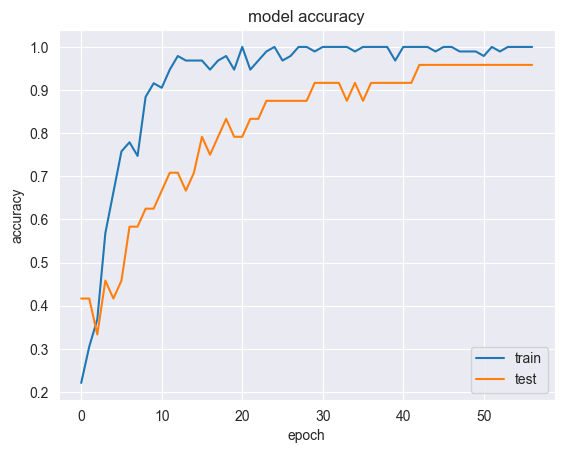

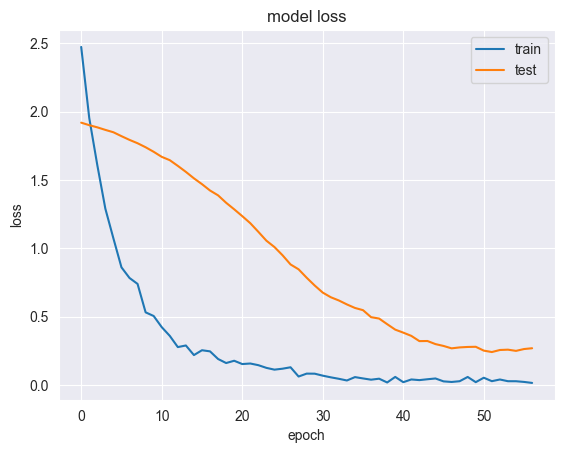

In [29]:
plt.plot(RNN_model_fit.history['acc'])
plt.plot(RNN_model_fit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(RNN_model_fit.history['loss'])
plt.plot(RNN_model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Посмотрим, на каких валидационных интентах модель RNN_model ошиблась

In [30]:
y_train_pred = RNN_model.predict(X_val)

1/1 [==============================] - 0s 149ms/step


Преобразуем двумерный массив с вероятностями в предсказания

In [31]:
y_train_res = bin_arr(y_train_pred)

Accuracy на валидационном наборе

In [32]:
accuracy_score(y_val, y_train_res)

0.9583333333333334

Занесем результаты в df_res

In [33]:
df_res = pd.DataFrame(columns=['Model', 'Accuracy'])
df_res.set_index('Model', inplace=True)

model = 'RNN_model'
df_res.loc[model] = accuracy_score(y_val, y_train_res)

Models = {'RNN_model': RNN_model}

df_res.head()

,Accuracy
Model,
RNN_model,0.958333


Посмотрим на матрицу ошибок модели RNN_mode

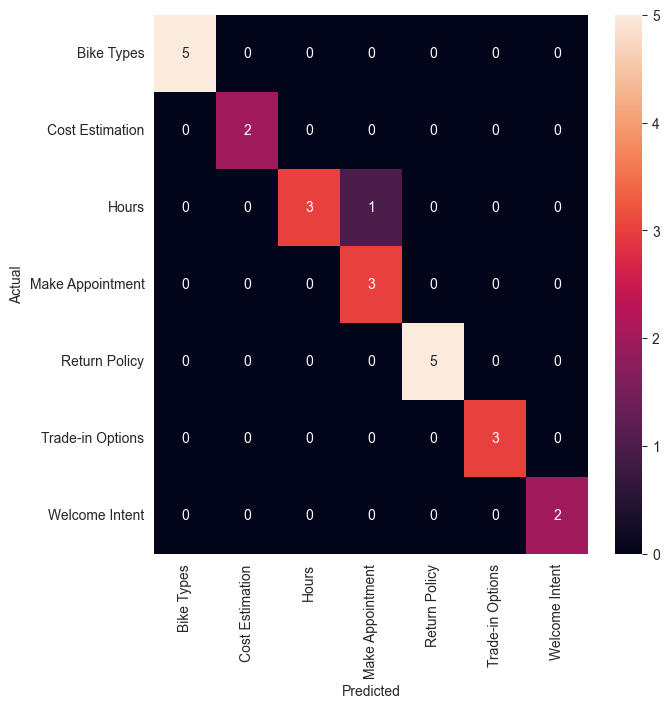

In [34]:
conf_mat = confusion_matrix(y_val.argmax(axis=1), y_train_res.argmax(axis=1))
# .values.argmax(axis=1), predictions.argmax(axis=1)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment', 'Return Policy', 'Trade-in Options', 'Welcome Intent'],
            yticklabels=['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment', 'Return Policy', 'Trade-in Options', 'Welcome Intent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Восстановим в датафрейме df_pred_val по эмбеддингу начальный запрос пользователя в столбце 'text', текстовое значение истинного класса в столбце 'y_val' и текстовое значение предскзания класса в столбце 'y_pred_rnn'

In [35]:
df_pred_val = pd.DataFrame()

val_text = []
for line in X_val:
    cnt_text = ''
    for el in line:
        if el !=0:
            if cnt_text != '':
                cnt_text += ' '+ token_text.index_word[el]
            else:
                cnt_text += token_text.index_word[el]
        else:
            continue
    val_text.append(cnt_text)

df_pred_val['text'] = val_text


In [36]:
val_res = []
for i in y_val:
    idx = np.nonzero(i)
    val_res.append(idx[0][0])

df_pred_val['y_val'] = label_encoder.inverse_transform(val_res)


In [37]:
pred_res = []
for i in y_train_res:
    idx = np.nonzero(i)
    pred_res.append(idx[0][0])

df_pred_val['y_pred_rnn'] = label_encoder.inverse_transform(pred_res)

df_pred_val

,text,y_val,y_pred_rnn
0,refund,Return Policy,Return Policy
1,hello,Welcome Intent,Welcome Intent
2,bikes women,Bike Types,Bike Types
3,got,Make Appointment,Make Appointment
4,open evening like 6pm,Hours,Hours
5,hello guys,Welcome Intent,Welcome Intent
6,take returns,Return Policy,Return Policy
7,bikes daily usage,Bike Types,Bike Types
8,bikes family,Bike Types,Bike Types
9,sell old bikes,Trade-in Options,Trade-in Options


Найдем запросы, в которых было дано ошибочное предсказание

In [38]:
df_conf_rnn = df_pred_val.loc[df_pred_val['y_pred_rnn'] != df_pred_val['y_val']]
df_conf_rnn

,text,y_val,y_pred_rnn
15,come,Hours,Make Appointment


Восстановим первоначальный текст и номер запроса в df_train для каждой ошибки

In [39]:
df_conf_rnn_train = df_train.loc[df_train['text_pure'].isin(df_conf_rnn['text'].values)]
df_conf_rnn_train

,text,intent,text_pure,intent_code
32,can I come in on,Hours,come,2


## LSTM

Про устройство сетей с долгой краткосрочной памятью (Long Short-Term Memory; LSTM) та же ссылка - https://digiratory.ru/575

In [40]:
LSTM_model = Sequential([
    Embedding(input_dim=max_words + 1, input_length=max_length, output_dim=64, mask_zero=True),
    Dropout(0.3),
    LSTM(32, return_sequences=True),

    # batch normalization layer - нормализует активации предыдущего слоя в каждом батче, т. е. применяет преобразование, которое поддерживает среднюю активацию близкой к 0, а стандартное отклонение активации близкой к 1.
    BatchNormalization(),
    # понижаем размерность входного представления, оставляя максимальное на текущий момент значение
    GlobalMaxPool1D(),

    Dropout(0.5),
    Dense(7, activation='sigmoid')
])

In [41]:
# LSTM_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['acc'])
LSTM_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

Инофрмация о модели LSTM_model

In [42]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 6, 64)             9664      
                                                                 
 dropout_2 (Dropout)         (None, 6, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 6, 32)             12416     
                                                                 
 batch_normalization_1 (Batc  (None, 6, 32)            128       
 hNormalization)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [43]:
tf.keras.utils.plot_model(LSTM_model, show_shapes=True, show_dtype=False, expand_nested=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
LSTM_model_fit = LSTM_model.fit(X_train, y_train, batch_size=512, epochs=500, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 2.0536 - acc: 0.1579 - val_loss: 1.9384 - val_acc: 0.3333
Epoch 2/500
1/1 [==============================] - 0s 24ms/step - loss: 1.9299 - acc: 0.2211 - val_loss: 1.9344 - val_acc: 0.3750
Epoch 3/500
1/1 [==============================] - 0s 24ms/step - loss: 1.7662 - acc: 0.3263 - val_loss: 1.9313 - val_acc: 0.3750
Epoch 4/500
1/1 [==============================] - 0s 27ms/step - loss: 1.7149 - acc: 0.3368 - val_loss: 1.9290 - val_acc: 0.3750
Epoch 5/500
1/1 [==============================] - 0s 23ms/step - loss: 1.6037 - acc: 0.4000 - val_loss: 1.9268 - val_acc: 0.3750
Epoch 6/500
1/1 [==============================] - 0s 30ms/step - loss: 1.5600 - acc: 0.4526 - val_loss: 1.9244 - val_acc: 0.3750
Epoch 7/500
1/1 [==============================] - 0s 26ms/step - loss: 1.4793 - acc: 0.5579 - val_loss: 1.9222 - val_acc: 0.3750
Epoch 8/500
1/1 [==============================] - 0s 26ms/step - loss: 1.3994 - acc: 0.6000

In [45]:
LSTM_train_score = LSTM_model.evaluate(X_val, y_val, batch_size = 1024, verbose = 1)
print('Train loss:', LSTM_train_score[0])
print('Train accuracy:', LSTM_train_score[1])

1/1 [==============================] - 0s 18ms/step - loss: 0.8151 - acc: 0.8750
Train loss: 0.8150661587715149
Train accuracy: 0.875


История обучения (accuracy и loss)

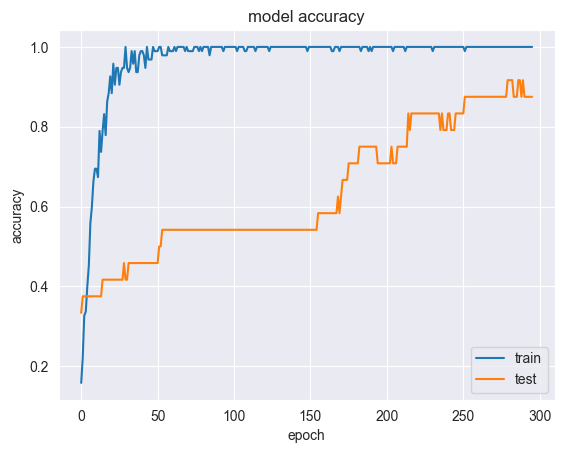

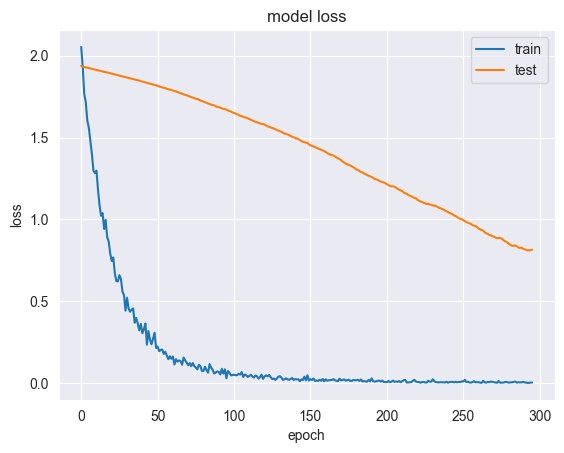

In [46]:
plt.plot(LSTM_model_fit.history['acc'])
plt.plot(LSTM_model_fit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(LSTM_model_fit.history['loss'])
plt.plot(LSTM_model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Посмотрим, на каких валидационных интентах модель LSTM_model ошиблась

In [47]:
y_train_pred = LSTM_model.predict(X_val)

1/1 [==============================] - 1s 904ms/step


Преобразуем двумерный массив с вероятностями в предсказания

In [48]:
y_train_res = bin_arr(y_train_pred)

Accuracy на валидационном наборе

In [49]:
accuracy_score(y_val, y_train_res)

0.875

Занесем результаты в df_res

In [50]:
model = 'LSTM_model'
df_res.loc[model] = accuracy_score(y_val, y_train_res)

Models['LSTM_model'] = LSTM_model

df_res.head()

,Accuracy
Model,
RNN_model,0.958333
LSTM_model,0.875000


Посмотрим на матрицу ошибок модели LSTM_model

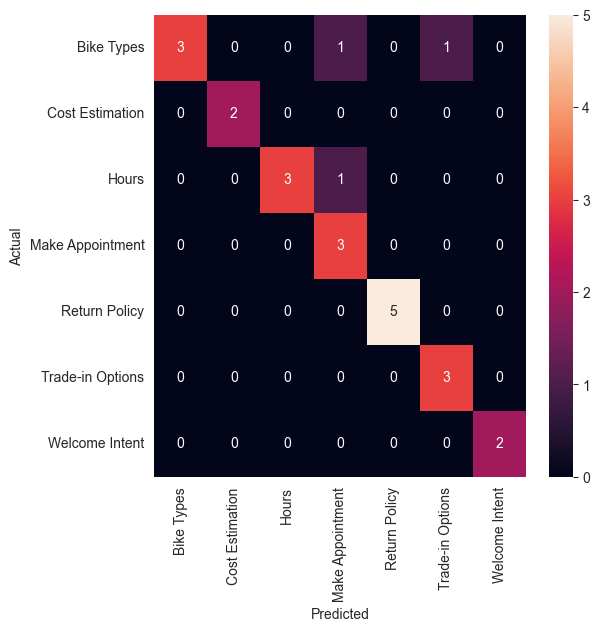

In [51]:
conf_mat = confusion_matrix(y_val.argmax(axis=1), y_train_res.argmax(axis=1))
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment', 'Return Policy', 'Trade-in Options', 'Welcome Intent'],
            yticklabels=['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment', 'Return Policy', 'Trade-in Options', 'Welcome Intent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Добавим в датафрейм df_pred_val текстовое значение предскзания класса модели LSTM_model в столбец 'y_pred_lstm'

In [52]:
pred_res = []
for i in y_train_res:
    idx = np.nonzero(i)
    pred_res.append(idx[0][0])

df_pred_val['y_pred_lstm'] = label_encoder.inverse_transform(pred_res)

df_pred_val

,text,y_val,y_pred_rnn,y_pred_lstm
0,refund,Return Policy,Return Policy,Return Policy
1,hello,Welcome Intent,Welcome Intent,Welcome Intent
2,bikes women,Bike Types,Bike Types,Trade-in Options
3,got,Make Appointment,Make Appointment,Make Appointment
4,open evening like 6pm,Hours,Hours,Hours
5,hello guys,Welcome Intent,Welcome Intent,Welcome Intent
6,take returns,Return Policy,Return Policy,Return Policy
7,bikes daily usage,Bike Types,Bike Types,Bike Types
8,bikes family,Bike Types,Bike Types,Bike Types
9,sell old bikes,Trade-in Options,Trade-in Options,Trade-in Options


Найдем запросы, в которых было дано ошибочное предсказание

In [53]:
df_conf_lstm = df_pred_val.loc[df_pred_val['y_pred_lstm'] != df_pred_val['y_val']]
df_conf_lstm

,text,y_val,y_pred_rnn,y_pred_lstm
2,bikes women,Bike Types,Bike Types,Trade-in Options
15,come,Hours,Make Appointment,Make Appointment
17,carbon fiber bike,Bike Types,Bike Types,Make Appointment


Восстановим первоначальный текст и номер запроса в df_train для каждой ошибки

In [54]:
df_conf_lstm_train = df_train.loc[df_train['text_pure'].isin(df_conf_lstm['text'].values)]
df_conf_lstm_train

,text,intent,text_pure,intent_code
0,Carbon fiber bike,Bike Types,carbon fiber bike,0
4,bikes for women,Bike Types,bikes women,0
32,can I come in on,Hours,come,2


## BERT

Про принцип работы сетей с языковой моделью, основанной на архитектуре трансформера (Bidirectional Encoder Representations from Transformers, BERT) см. ссылку https://hannibunny.github.io/mlbook/transformer/intent_classification_with_bert.html

Поскольку в модели используется свой эмбеддинг, восстановим исходные тексты запросов, которые попали в трейновый и валидационные наборы датафрейма df_train

In [72]:
val_text = []
for line in X_val:
    cnt_text = ''
    for el in line:
        if el != 0:
            if cnt_text != '':
                cnt_text += ' ' + token_text.index_word[el]
            else:
                cnt_text += token_text.index_word[el]
        else:
            continue
    val_text.append(cnt_text)

print(val_text)

['refund', 'hello', 'bikes women', 'got', 'open evening like 6pm', 'hello guys', 'take returns', 'bikes daily usage', 'bikes family', 'sell old bikes', 'price changing seat', 'tradeins', 'have bikes beginner', 'open hours afternoon', 'tuneups', 'come', 'buy bikes', 'carbon fiber bike', 'time close saturday morning', 'much get refund change', 'bike fit me return it', 'need', 'know price', 'want return']


In [73]:
train_text = []
n = 1
for line in X_train:
    cnt_text = ''
    for el in line:
        if el != 0:
            if cnt_text != '':
                cnt_text += ' ' + token_text.index_word[el]
            else:
                cnt_text += token_text.index_word[el]
        # else:
        #     continue
    train_text.append(cnt_text)

print(train_text)

['make appointment come in', 'professional cyclist options have store me', 'types bikes have store', 'return bike purchased', 'return money', 'when store open', 'take returns bikes', 'price tire replacement', 'when open', 'full refund', 'sell bike', 'weekday schedule', 'much get refund purchase', 'return policy', 'bikes good commuting', 'when come in', 'tradein used bikes', 'return bike', 'hours', 'setup appointment', 'get new bike take old one', 'bikes kids', 'take bikes different shops', 'need return', 'need adjust seat', 'bike broken', 'when drop bike', 'carry mountain bike', 'restrictions returning bike', 'business hours', 'like learn tradein options', 'budget bikes road trail', 'appointment', 'old sell tradeins', 'sell bike you', 'open', 'price adjusting seat', 'cost', 'meet', 'store hours', 'lightweighted bikes', 'bike good beginner', 'old bikes', 'bikes men', 'sell ebikes', 'seat high me need', 'bike road', 'looking bike son', 'need trade in', 'closed morning', 'average cost', "

Подготовим трейновые и валидационные данные в нужном для модели виде

In [74]:
X_train_ = np.array(train_text)
X_val_ = np.array(val_text)

Импортируем предобученную модель 'bert_en_cased_L-12_H-768_A-12' для файн тьюнинга

In [75]:
bert_model_name = 'bert_en_cased_L-12_H-768_A-12'
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

С каждой выбранной моделью BERT связан свой препроцессинг исходных текстов

In [76]:
map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2


In [77]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2023-04-05 03:41:42.416230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-05 03:41:42.416887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-05 03:41:42.417087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-05 03:41:42.422509: I tensorflow/core/

После препроцессинга текст определяется по 3 выходам, которые будет использовать модель BERT (input_words_id, input_mask и input_type_ids).
input_words_id - представление запроса;
input_mask - разделяет содержимое запроса и паддинги;
input_type_ids - разделяет содержимое запроса по предложениям

In [78]:
text_test = [X_train_[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1294 5516 1435 1107  102    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Построим послойно модель BERT

In [79]:
def build_BERT_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Токенизация входного текста
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(7, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)


In [80]:
X_train_[0]

'make appointment come in'

Информация о BERT модели

In [81]:
BERT_model = build_BERT_model()

BERT_model.summary()

2023-04-05 03:42:19.618683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-05 03:42:19.619115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-05 03:42:19.619827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-05 03:42:19.621076: I tensorflow/core/

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

2023-04-05 03:42:27.293931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-04-05 03:42:27.293993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_2' with dtype int32 and shape [?,128]
	 [[{{node inputs_2}}]]
2023-04-05 03:42:27.373526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [?,128]
	 [[{{node Placeholder_1}}]

Определим параметры, по которым будет происходить обучение модели

In [82]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [83]:
optimizer = tf.keras.optimizers.Adam(1e-5)
BERT_model.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=metrics)

In [84]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5)

In [85]:
epochs = 15

print(f'Training model with {tfhub_handle_encoder}')

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3


In [86]:
BERT_model_fit = BERT_model.fit(x=X_train_, y=y_train,
                         validation_data=[X_val_, y_val],
                         batch_size=8,
                         epochs=epochs,
                         callbacks=[early_stopping_callback])


Epoch 1/15


2023-04-05 03:43:04.212420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-04-05 03:43:04.212485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_2' with dtype int32 and shape [?,128]
	 [[{{node inputs_2}}]]
2023-04-05 03:43:09.751781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPart

12/12 [==============================] - 66s 4s/step - loss: 2.0975 - categorical_accuracy: 0.2105 - val_loss: 1.9184 - val_categorical_accuracy: 0.2500
Epoch 2/15
12/12 [==============================] - 46s 4s/step - loss: 1.7640 - categorical_accuracy: 0.2632 - val_loss: 1.7362 - val_categorical_accuracy: 0.4167
Epoch 3/15
12/12 [==============================] - 45s 4s/step - loss: 1.5412 - categorical_accuracy: 0.3895 - val_loss: 1.5716 - val_categorical_accuracy: 0.4167
Epoch 4/15
12/12 [==============================] - 45s 4s/step - loss: 1.3072 - categorical_accuracy: 0.5263 - val_loss: 1.4002 - val_categorical_accuracy: 0.5833
Epoch 5/15
12/12 [==============================] - 46s 4s/step - loss: 1.2014 - categorical_accuracy: 0.6211 - val_loss: 1.2203 - val_categorical_accuracy: 0.6667
Epoch 6/15
12/12 [==============================] - 45s 4s/step - loss: 1.0239 - categorical_accuracy: 0.7053 - val_loss: 1.0241 - val_categorical_accuracy: 0.7500
Epoch 7/15
12/12 [=========

In [87]:
loss, accuracy = BERT_model.evaluate(X_val_, y_val)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 4s 4s/step - loss: 0.2746 - categorical_accuracy: 0.9167
Loss: 0.27462464570999146
Accuracy: 0.9166666865348816


История обучения (accuracy и loss)

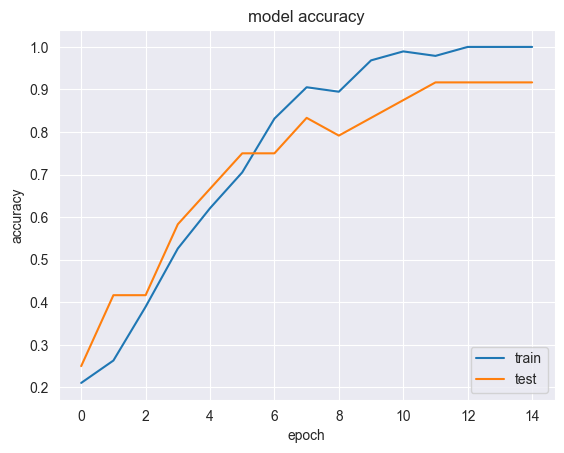

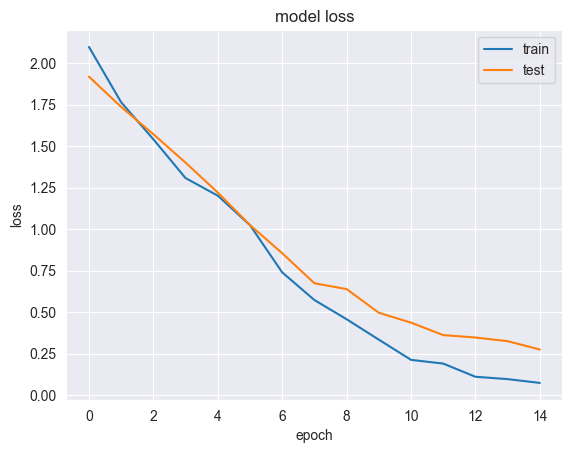

In [88]:
plt.plot(BERT_model_fit.history['categorical_accuracy'])
plt.plot(BERT_model_fit.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(BERT_model_fit.history['loss'])
plt.plot(BERT_model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Посмотрим, на каких валидационных интентах модель BERT_model ошиблась

In [89]:
y_train_pred = BERT_model.predict(X_val_)

1/1 [==============================] - 4s 4s/step


Преобразуем двумерный массив с вероятностями в предсказания

In [90]:
y_train_res = bin_arr(y_train_pred)

Accuracy на валидационном наборе

In [91]:
accuracy_score(y_val, y_train_res)

0.9166666666666666

Занесем результаты в df_res

In [92]:
model = 'BERT_model'
df_res.loc[model] = accuracy_score(y_val, y_train_res)

Models['BERT_model'] = BERT_model

df_res.head()

,Accuracy
Model,
RNN_model,0.958333
LSTM_model,0.875000
BERT_model,0.916667


Посмотрим на матрицу ошибок модели BERT_model

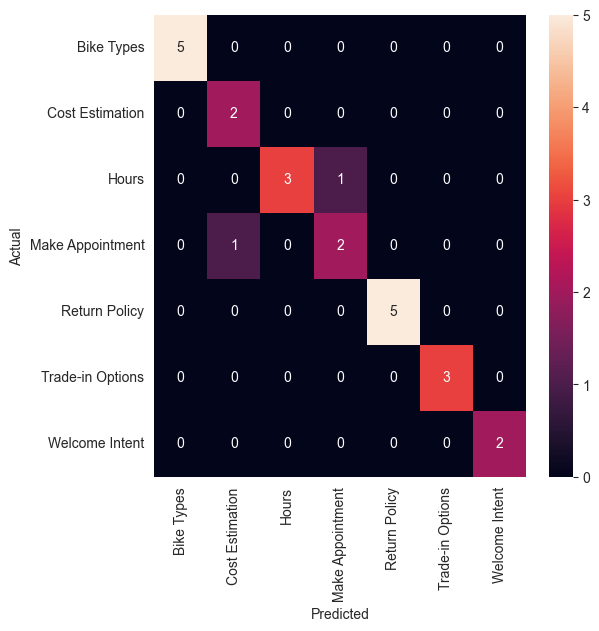

In [93]:
conf_mat = confusion_matrix(y_val.argmax(axis=1), y_train_res.argmax(axis=1))
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment', 'Return Policy',
                         'Trade-in Options', 'Welcome Intent'],
            yticklabels=['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment', 'Return Policy',
                         'Trade-in Options', 'Welcome Intent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Добавим в датафрейм df_pred_val текстовое значение предскзания класса модели BERT_model в столбец ‘y_pred_bert’

In [94]:
pred_res = []
for i in y_train_res:
    idx = np.nonzero(i)
    pred_res.append(idx[0][0])

df_pred_val['y_pred_bert'] = label_encoder.inverse_transform(pred_res)

df_pred_val

,text,y_val,y_pred_rnn,y_pred_lstm,y_pred_bert
0,refund,Return Policy,Return Policy,Return Policy,Return Policy
1,hello,Welcome Intent,Welcome Intent,Welcome Intent,Welcome Intent
2,bikes women,Bike Types,Bike Types,Trade-in Options,Bike Types
3,got,Make Appointment,Make Appointment,Make Appointment,Make Appointment
4,open evening like 6pm,Hours,Hours,Hours,Hours
5,hello guys,Welcome Intent,Welcome Intent,Welcome Intent,Welcome Intent
6,take returns,Return Policy,Return Policy,Return Policy,Return Policy
7,bikes daily usage,Bike Types,Bike Types,Bike Types,Bike Types
8,bikes family,Bike Types,Bike Types,Bike Types,Bike Types
9,sell old bikes,Trade-in Options,Trade-in Options,Trade-in Options,Trade-in Options


Найдем запросы, в которых было дано ошибочное предсказание

In [95]:
df_conf_bert = df_pred_val.loc[df_pred_val['y_pred_bert'] != df_pred_val['y_val']]
df_conf_bert

,text,y_val,y_pred_rnn,y_pred_lstm,y_pred_bert
14,tuneups,Make Appointment,Make Appointment,Make Appointment,Cost Estimation
15,come,Hours,Make Appointment,Make Appointment,Make Appointment


Восстановим первоначальный текст и номер запроса в df_train для каждой ошибки

In [96]:
df_conf_bert_train = df_train.loc[df_train['text_pure'].isin(df_conf_bert['text'].values)]
df_conf_bert_train

,text,intent,text_pure,intent_code
32,can I come in on,Hours,come,2
44,tune-ups,Make Appointment,tuneups,3


# Bonus

## CNN

Про устройство сверточных нейронных (Convolutional Neural Network; LSTM) та же ссылка https://habr.com/ru/companies/ods/articles/353060/

Построим модель CNN_model

In [97]:
CNN_model = Sequential([
    Embedding(input_dim=max_words + 1, input_length=max_length, output_dim=64, mask_zero=True),

    # Одномерный слой свертки. Создаем ядро свертки, которое сворачивается с входными данными слоя в одном  измерении для создания тензора выходных данных.
    Conv1D(256, kernel_size=2, activation = 'relu'),

    # Понизим входное представление, оставляя максимальное значение в пространственном окне размером pool_size. Окно смещается на 1 шаг.
    MaxPool1D(pool_size=(6 - 2 + 1), strides=1, padding='valid'),

    # Выравниваем данные
    Flatten(),

    Dropout(0.3),
    Dense(7, activation = 'sigmoid')
])

In [98]:
CNN_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Инофрмация о модели CNN_model

In [99]:
CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 6, 64)             9664      
                                                                 
 conv1d (Conv1D)             (None, 5, 256)            33024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 256)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                      

In [100]:
tf.keras.utils.plot_model(CNN_model, show_shapes=True, show_dtype=False, expand_nested=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [101]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
CNN_model_fit = CNN_model.fit(X_train, y_train, batch_size=1024, epochs=300, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/300
1/1 [==============================] - 1s 630ms/step - loss: 1.9480 - accuracy: 0.0842 - val_loss: 1.9362 - val_accuracy: 0.1667
Epoch 2/300
1/1 [==============================] - 0s 23ms/step - loss: 1.9300 - accuracy: 0.2737 - val_loss: 1.9291 - val_accuracy: 0.2500
Epoch 3/300
1/1 [==============================] - 0s 24ms/step - loss: 1.9167 - accuracy: 0.3684 - val_loss: 1.9223 - val_accuracy: 0.2500
Epoch 4/300
1/1 [==============================] - 0s 26ms/step - loss: 1.9038 - accuracy: 0.3789 - val_loss: 1.9158 - val_accuracy: 0.2500
Epoch 5/300
1/1 [==============================] - 0s 22ms/step - loss: 1.8918 - accuracy: 0.4211 - val_loss: 1.9098 - val_accuracy: 0.2500
Epoch 6/300
1/1 [==============================] - 0s 22ms/step - loss: 1.8754 - accuracy: 0.4526 - val_loss: 1.9040 - val_accuracy: 0.2500
Epoch 7/300
1/1 [==============================] - 0s 24ms/step - loss: 1.8645 - accuracy: 0.5053 - val_loss: 1.8981 - val_accuracy: 0.2500
Epoch 8/300
1/1 [==

In [102]:
CNN_train_score = CNN_model.evaluate(X_val, y_val, batch_size = 1024, verbose = 1)
print('Train loss:', CNN_train_score[0])
print('Train accuracy:', CNN_train_score[1])

1/1 [==============================] - 0s 19ms/step - loss: 0.3358 - accuracy: 0.9167
Train loss: 0.3357762098312378
Train accuracy: 0.9166666865348816


История обучения (accuracy и loss)

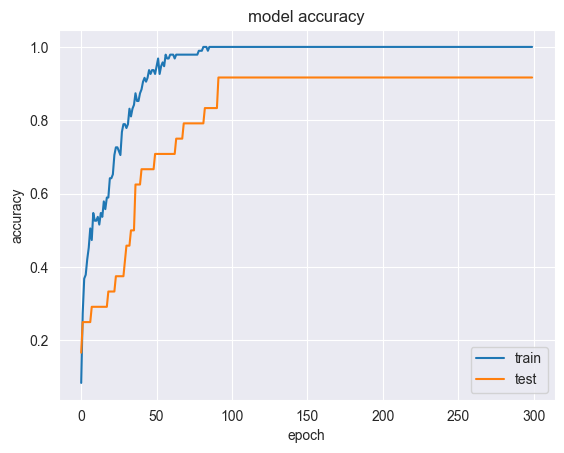

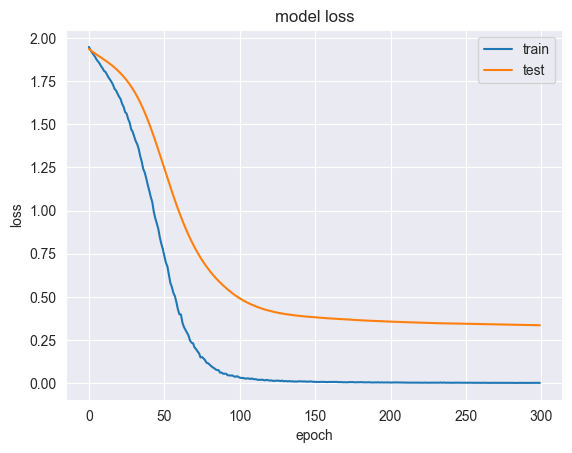

In [103]:
plt.plot(CNN_model_fit.history['accuracy'])
plt.plot(CNN_model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(CNN_model_fit.history['loss'])
plt.plot(CNN_model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Посмотрим, на каких валидационных интентах модель CNN_model ошиблась

In [104]:
y_train_pred = CNN_model.predict(X_val)

1/1 [==============================] - 0s 50ms/step


Преобразуем двумерный массив с вероятностями в предсказания

In [105]:
y_train_res = bin_arr(y_train_pred)

Accuracy на валидационном наборе

In [106]:
accuracy_score(y_val, y_train_res)

0.9166666666666666

Занесем результаты в df_res

In [107]:
model = 'CNN_model'
df_res.loc[model] = accuracy_score(y_val, y_train_res)

Models['CNN_model'] = CNN_model

df_res.head()

,Accuracy
Model,
RNN_model,0.958333
LSTM_model,0.875000
BERT_model,0.916667
CNN_model,0.916667


Посмотрим на матрицу ошибок модели LSTM_model

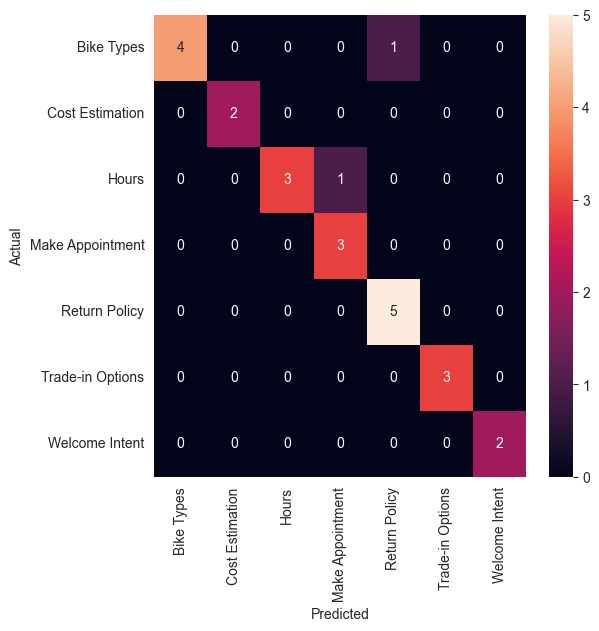

In [108]:
conf_mat = confusion_matrix(y_val.argmax(axis=1), y_train_res.argmax(axis=1))
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment', 'Return Policy', 'Trade-in Options', 'Welcome Intent'],
            yticklabels=['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment', 'Return Policy', 'Trade-in Options', 'Welcome Intent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Добавим в датафрейм df_pred_val текстовое значение предскзания класса модели LSTM_model в столбец ‘y_pred_cnn’

In [109]:
pred_res = []
for i in y_train_res:
    idx = np.nonzero(i)
    pred_res.append(idx[0][0])

df_pred_val['y_pred_cnn'] = label_encoder.inverse_transform(pred_res)

df_pred_val

,text,y_val,y_pred_rnn,y_pred_lstm,y_pred_bert,y_pred_cnn
0,refund,Return Policy,Return Policy,Return Policy,Return Policy,Return Policy
1,hello,Welcome Intent,Welcome Intent,Welcome Intent,Welcome Intent,Welcome Intent
2,bikes women,Bike Types,Bike Types,Trade-in Options,Bike Types,Bike Types
3,got,Make Appointment,Make Appointment,Make Appointment,Make Appointment,Make Appointment
4,open evening like 6pm,Hours,Hours,Hours,Hours,Hours
5,hello guys,Welcome Intent,Welcome Intent,Welcome Intent,Welcome Intent,Welcome Intent
6,take returns,Return Policy,Return Policy,Return Policy,Return Policy,Return Policy
7,bikes daily usage,Bike Types,Bike Types,Bike Types,Bike Types,Bike Types
8,bikes family,Bike Types,Bike Types,Bike Types,Bike Types,Bike Types
9,sell old bikes,Trade-in Options,Trade-in Options,Trade-in Options,Trade-in Options,Trade-in Options


Найдем запросы, в которых было дано ошибочное предсказание

In [110]:
df_conf_cnn = df_pred_val.loc[df_pred_val['y_pred_cnn'] != df_pred_val['y_val']]
df_conf_cnn

,text,y_val,y_pred_rnn,y_pred_lstm,y_pred_bert,y_pred_cnn
15,come,Hours,Make Appointment,Make Appointment,Make Appointment,Make Appointment
17,carbon fiber bike,Bike Types,Bike Types,Make Appointment,Bike Types,Return Policy


Восстановим первоначальный текст и номер запроса в df_train для каждой ошибки

In [111]:
df_conf_cnn_train = df_train.loc[df_train['text_pure'].isin(df_conf_cnn['text'].values)]
df_conf_cnn_train

,text,intent,text_pure,intent_code
0,Carbon fiber bike,Bike Types,carbon fiber bike,0
32,can I come in on,Hours,come,2


# Results

Итоговая таблица по моделям на тестовых значениях выглядит так:

In [112]:
df_res.sort_values(by='Accuracy', ascending=False, inplace=True)
df_res.head()

,Accuracy
Model,
RNN_model,0.958333
BERT_model,0.916667
CNN_model,0.916667
LSTM_model,0.875000


## Subject task
Полученная модель должна быть сохранена в формате pickle

In [113]:
best_model = list(df_res.index[[0]])[0]


with open('data/best_model.pkl', 'wb') as fp:
    pickle.dump(Models[best_model], fp)

## Subject task
Результаты для тестового набора должны быть сохранены в файл с именем intents.csv

Для разметки запросов из тестового файла будем использовать сохраненную модель, показавшую лучший результат по Accuracy

In [114]:
with open('data/best_model.pkl', 'rb') as fp:
    best_model = pickle.load(fp)

Размер подготовленного выше тестового шейпа

In [115]:
texts_test_full.shape

(37, 6)

Делаем предсказания интентов по запросам

In [116]:
intents_test_pred = best_model.predict(texts_test_full)

2/2 [==============================] - 0s 3ms/step


Восстановим текстовое значение предскзания класса в столбце 'intent' датафрейма df_test

In [117]:
intents_test_res = bin_arr(intents_test_pred)

In [119]:
pred_res = []
for i in intents_test_res:
    idx = np.nonzero(i)
    pred_res.append(idx[0][0])

df_test['intent'] = label_encoder.inverse_transform(pred_res)

df_test

,text,text_pure,intent
0,Do I need to replace my helmet?,need replace helmet,Make Appointment
1,My bike was stolen what should I do?,bike stolen do,Make Appointment
2,What types or choices of bikes do I have in yo...,types choices bikes have store,Bike Types
3,Do you rent bikes?,rent bikes,Bike Types
4,I'm a student and I'm doing a project...,student project,Bike Types
5,Can I bring my dog into your shop?,bring dog shop,Bike Types
6,Do you match prices?,match prices,Bike Types
7,can I get an appointment tomorrow?,get appointment tomorrow,Make Appointment
8,How much to repair my bike?,much repair bike,Cost Estimation
9,How do I know what size tire/tube I need?,know size tiretube need,Return Policy


Сохраняем результат в требуемый файл

In [ ]:
df_test[['text', 'intent']].to_csv('data/intents.csv')

************************************************************
************************************************************